# Bayesian Data Analysis - Project

In [43]:
%%capture
import pystan
from psis import *
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, Math, Latex
from IPython.display import HTML, display

In [46]:
year_list = []
life_expectancy_data = []
with open("lifex.csv", "r") as ifile:
    year_list = [int(x) for x in ifile.readline().split(",")[1:-1]] # add n to first index to skip first n values
    for line in ifile:
        life_expectancy_data.append([float(x) for x in line.split(",")[1:-1]]) # same here

life_expectancy_data = np.array(life_expectancy_data)
N = life_expectancy_data.shape[1]
K = life_expectancy_data.shape[0]
#ind = [x+1 for x in range(life_expectancy_data.shape[0]) for _ in range(life_expectancy_data.shape[1])]
y = life_expectancy_data
x = year_list
xpred = [2017, 2018, 2019, 2020, 2030, 2050]
stan_data = dict(N=N, K=K, x=x, y=y, ind=ind, xpred=xpred, M=len(xpred))


### Separate model

In [47]:
code_separate = """
data {
    int<lower=0> N;  // number of data points
    int<lower=0> K;  // number of countries
    vector[N] x;     // observation year
    matrix[K, N] y;  // observation life expectancy
    int<lower=0> M;  // number of predictions
    real xpred[M];      // prediction year
}
parameters {
    real alpha[K];
    real beta[K];
    real<lower=0> sigma[K];
}
transformed parameters {
    vector[N] mu[K];
    for (k in 1:K)
        mu[k] = alpha[k] + beta[k]*x;
}
model {
    //beta ~ normal(0, 18.5483); //assign priors here
    for (k in 1:K)
        y[k] ~ normal(mu[k], sigma[k]);
}
generated quantities {
    real ypred[K, M];
    matrix[K, N] log_lik;
    for (k in 1:K)
        for (m in 1:M)
            ypred[k,m] = normal_rng(alpha[k]+beta[k]*xpred[m], sigma[k]);
    for (k in 1:K)
        for (n in 1:N)
            log_lik[k, n] <- normal_log(y[k, n], mu[k][n], sigma[k]);
}
"""
sm_separate = pystan.StanModel(model_code=code_separate)

/opt/conda/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp5o88vd95/stanfit4anon_model_23c5e52a92246bcea8cc2cd1d0780116_3941377176262403067.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


We can then sample from the model with the data.

In [48]:
fit_separate = sm_separate.sampling(data=stan_data, iter=4000); #, iter=4000
samples_separate = fit_separate.extract(permuted=True);
print(samples_separate["log_lik"].shape)

(8000, 5, 57)


In [50]:
log_lik_separate = samples_separate["log_lik"].reshape(samples_separate["log_lik"].shape[0], samples_separate["log_lik"].shape[1]*samples_separate["log_lik"].shape[2])
sep_loo, sep_loos, sep_ks = psisloo(log_lik_separate)
sep_lppd = np.sum(np.log(np.mean(np.exp(log_lik_separate), axis=0)))
sep_peff = sep_lppd-sep_loo
# print(sep_loo)
# print(sep_peff)
# print(sum(sep_ks<.7)/len(sep_ks))

### Pooled model
absolutely useless in this case

In [6]:
code_pooled = """
data {
    int<lower=0> N;  // number of data points
    int<lower=0> K;  // number of countries
    //int<lower=0, upper=K> ind[N]; // country indicator
    vector[N] x;     // observation year
    matrix[K, N] y;  // observation life expectancy
    real xpred;      // prediction year
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}
transformed parameters {
    vector[N] mu;
    mu = alpha + beta*x;
}
model {
    //beta ~ normal(0, 18.5483); //assign priors here
    for (k in 1:K)
        y[k] ~ normal(mu, sigma);
}
generated quantities {
    real ypred[K];
    for (k in 1:K)
        ypred[k] = normal_rng(alpha+beta*xpred, sigma);
}
"""
sm_pooled = pystan.StanModel(model_code=code_pooled)

/opt/conda/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpsu9v5fj4/stanfit4anon_model_a032551cfd11e42adfb10f4c00f3c6d4_1855022194978445426.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [ ]:
fit = sm_pooled.sampling(data=stan_data);
# print(fit)

### Hierarchical model

In [52]:
code_hierarchical = """
data {
    int<lower=0> N;  // number of data points
    int<lower=0> K;  // number of countries
    vector[N] x;     // observation year
    matrix[K, N] y;  // observation life expectancy
    int<lower=0> M;  // number of predictions
    real xpred[M];      // prediction year
}
parameters {
    real alpha[K];
    real alpha0;
    real beta[K];
    real beta0;
    real<lower=0> sigma;
    real<lower=0> sigmaalpha;
    real<lower=0> sigmabeta;
}
transformed parameters {
    vector[N] mu[K];
    for (k in 1:K)
        mu[k] = alpha[k] + beta[k]*x;
}
model {
    alpha ~ normal(alpha0, sigmaalpha);
    beta  ~ normal(beta0, sigmabeta);
    //beta ~ normal(0, 18.5483); //assign priors here
    for (k in 1:K)
        y[k] ~ normal(mu[k], sigma);
}
generated quantities {
    real ypred[K, M];
    matrix[K, N] log_lik;
    for (k in 1:K)
        for (m in 1:M)
            ypred[k,m] = normal_rng(alpha[k]+beta[k]*xpred[m], sigma);
    for (k in 1:K)
        for (n in 1:N)
            log_lik[k, n] <- normal_log(y[k, n], mu[k][n], sigma);
    
}
"""
sm_hierarchical = pystan.StanModel(model_code=code_hierarchical)

/opt/conda/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpm8bjxmxw/stanfit4anon_model_ec212b0a2d5d1f302172dfb4149463ce_6659576775962529023.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [53]:
fit_hier = sm_hierarchical.sampling(data=stan_data, iter=4000);
samples_hier = fit_hier.extract(permuted=True);
print(samples_hier["log_lik"].shape)


(8000, 5, 57)


In [54]:
log_lik_hier = samples_hier["log_lik"].reshape(samples_hier["log_lik"].shape[0], samples_hier["log_lik"].shape[1]*samples_hier["log_lik"].shape[2])
hier_loo, hier_loos, hier_ks = psisloo(log_lik_hier)
hier_lppd = np.sum(np.log(np.mean(np.exp(log_lik_hier), axis=0)))
hier_peff = hier_lppd-hier_loo
# print(hier_loo)
# print(hier_peff)
# print(sum(hier_ks<.7)/len(hier_ks))


In [56]:
data = [[sep_loo, sep_peff],
        [hier_loo, hier_peff]]
table = pd.DataFrame(data, index=["Separate",  "Hierarchical"],
                     columns=["PSIS-LOO", "p_eff"])
display(HTML(table.to_html()))

,PSIS-LOO,p_eff
Separate,-225.708868,14.772122
Hierarchical,-270.962374,12.977171


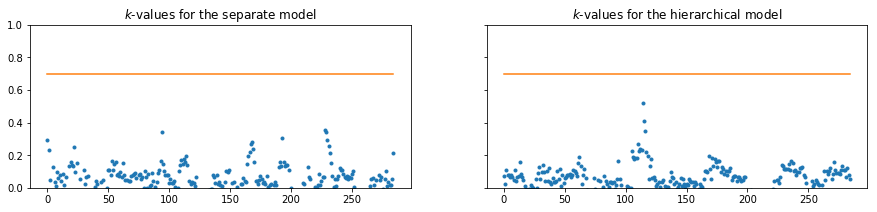

In [57]:
f, ax = plt.subplots(1, 2, sharey=True, figsize=(15, 3));
ax[0].plot(sep_ks, ".");
ax[0].plot([.7 for _ in sep_ks]);
ax[0].set_ylim((0,1));
ax[0].set_title("$k$-values for the separate model");
ax[1].plot(hier_ks, ".");
ax[1].plot([.7 for _ in hier_ks]);
ax[1].set_title("$k$-values for the hierarchical model");

[82.61711534 82.40558347 82.69151439 ... 81.64933815 80.67381445
 82.24801221]


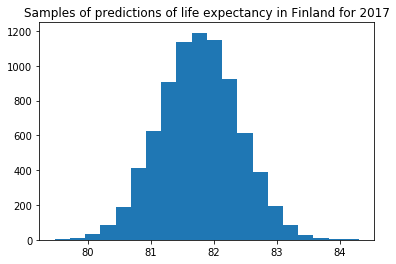

In [64]:
# get all samples of a certain county and year
# samples_hier - hierarchical model, samples_separate - separate model
print(samples_hier['ypred'][:, 0, 0]) #second index is the country index (0=FI, 1=BG, 2=SL, 3=ES, 4=DE)
                                      #third index is the year index in the 'xpred' list
plt.hist(samples_hier['ypred'][:, 0, 0], bins = 20)
plt.title("Samples of predictions of life expectancy in Finland for 2017")
plt.show()
# to get rhat values just print the fit - fit_separate or fit_hier
#print(fit_separate)
